# Spotify Artist and Track Clustering by Genre

In [1]:
#Import modules
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#### Load and format artists and tracks datasets

In [2]:
#Read in artist and track data
artistsFile = 'artists.csv'
artists = pd.read_csv(artistsFile)

tracksFile = 'tracks.csv'
tracks = pd.read_csv(tracksFile)

In [3]:
#Artists and tracks data both have 'popularity' and 'name' variable so rename the columns to be distinct
artists.rename(columns={'popularity':'popularity_artists'},inplace=True)
artists.rename(columns={'name':'name_artists'},inplace=True)
tracks.rename(columns={'popularity':'popularity_tracks'},inplace=True)
tracks.rename(columns={'name':'name_tracks'},inplace=True)

#Reformat some tracks columns for plotting
tracks['release_date'] = pd.to_datetime(tracks['release_date'])
tracks['release_year'] = tracks['release_date'].dt.year

#Replace empty genres in artists dataset with nans
artists.loc[artists.genres=='[]','genres'] = np.nan

#### Quick peek at artist and track datasets

In [4]:
#Subset of artists columns
artists

id  followers                 genres  \
0        0DheY5irMjBUeLybbCUEZ2        0.0                    NaN   
1        0DlhY15l3wsrnlfGio2bjU        5.0                    NaN   
2        0DmRESX2JknGPQyO15yxg7        0.0                    NaN   
3        0DmhnbHjm1qw6NCYPeZNgJ        0.0                    NaN   
4        0Dn11fWM7vHQ3rinvWEl4E        2.0                    NaN   
...                         ...        ...                    ...   
1104344  6rJIG42vcWAf1UBdRFlQxB     3345.0                    NaN   
1104345  1ljurfXKPlGncNdW3J8zJ8     2123.0  ['deep acoustic pop']   
1104346  2vnT9YhKIvjVo9LnVjWmr2       26.0                    NaN   
1104347  3ID0E5XCvnJIYZEq043ZoB      406.0                    NaN   
1104348  5m0Y4WSYyai2BU752lCASy      146.0                    NaN   

                                           name_artists  popularity_artists  
0        Armid & Amir Zare Pashai feat. Sara Rouzbehani                   0  
1                                           ปูนา ภาวิณี                   0  
2                                                 Sadaa                   0  
3                                             Tra'gruda                   0  
4                                Ioannis Panoutsopoulos                   0  
...                                                 ...                 ...  
1104344                                      Cody Longo                   8  
1104345                                 Right the Stars                  18  
1104346                                  Jesse Giddings                   0  
1104347                            The Boy Band Project                   0  
1104348                                      10 Reasons                   1  

[1104349 rows x 5 columns]

In [5]:
#Concise look at artist dataset
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104349 entries, 0 to 1104348
Data columns (total 5 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1104349 non-null  object 
 1   followers           1104336 non-null  float64
 2   genres              298616 non-null   object 
 3   name_artists        1104349 non-null  object 
 4   popularity_artists  1104349 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 42.1+ MB


In [6]:
#Subset of tracks columns
tracks

id                          name_tracks  \
0       35iwgR4jXetI318WEWsa1Q                                Carve   
1       021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista   
2       07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado   
3       08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado   
4       08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening   
...                        ...                                  ...   
586667  5rgu12WBIHQtvej2MdHSH0                                  云与海   
586668  0NuWgxEp51CutD2pJoF4OM                                blind   
586669  27Y1N4Q4U3EfDU5Ubw8ws2            What They'll Say About Us   
586670  45XJsGpFTyzbzeWK8VzR8S                      A Day At A Time   
586671  5Ocn6dZ3BJFPWh4ylwFXtn                     Mar de Emociones   

        popularity_tracks  duration_ms  explicit  \
0                       6       126903         0   
1                       0        98200         0   
2                       0       181640         0   
3                       0       176907         0   
4                       0       163080         0   
...                   ...          ...       ...   
586667                 50       258267         0   
586668                 72       153293         0   
586669                 70       187601         0   
586670                 58       142003         0   
586671                 38       214360         0   

                                artists  \
0                               ['Uli']   
1                   ['Fernando Pessoa']   
2                   ['Ignacio Corsini']   
3                   ['Ignacio Corsini']   
4                       ['Dick Haymes']   
...                                 ...   
586667                      ['阿YueYue']   
586668                   ['ROLE MODEL']   
586669                      ['FINNEAS']   
586670  ['Gentle Bones', 'Clara Benin']   
586671                    ['Afrosound']   

                                               id_artists release_date  \
0                              ['45tIt06XoI0Iio4LBEVpls']   1922-02-22   
1                              ['14jtPCOoNZwquk5wd9DxrY']   1922-06-01   
2                              ['5LiOoJbxVSAMkBS2fUm3X2']   1922-03-21   
3                              ['5LiOoJbxVSAMkBS2fUm3X2']   1922-03-21   
4                              ['3BiJGZsyX9sJchTqcSA7Su']   1922-01-01   
...                                                   ...          ...   
586667                         ['1QLBXKM5GCpyQQSVMNZqrZ']   2020-09-26   
586668                         ['1dy5WNgIKQU6ezkpZs4y8z']   2020-10-21   
586669                         ['37M5pPGs6V1fchFJSgCguX']   2020-09-02   
586670  ['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...   2021-03-05   
586671                         ['0i4Qda0k4nf7jnNHmSNpYv']   2015-07-01   

        danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0              0.645  0.4450  ...   -13.338     1       0.4510         0.674   
1              0.695  0.2630  ...   -22.136     1       0.9570         0.797   
2              0.434  0.1770  ...   -21.180     1       0.0512         0.994   
3              0.321  0.0946  ...   -27.961     1       0.0504         0.995   
4              0.402  0.1580  ...   -16.900     0       0.0390         0.989   
...              ...     ...  ...       ...   ...          ...           ...   
586667         0.560  0.5180  ...    -7.471     0       0.0292         0.785   
586668         0.765  0.6630  ...    -5.223     1       0.0652         0.141   
586669         0.535  0.3140  ...   -12.823     0       0.0408         0.895   
586670         0.696  0.6150  ...    -6.212     1       0.0345         0.206   
586671         0.686  0.7230  ...    -7.067     1       0.0363         0.105   

        instrumentalness  liveness  valence    tempo  time_signature  \
0               0.744000    0.1510   0.1270  104.851               3   
1               0.000000    0.1480   0.

In [7]:
#Concise look at tracks data
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 586672 non-null  object        
 1   name_tracks        586601 non-null  object        
 2   popularity_tracks  586672 non-null  int64         
 3   duration_ms        586672 non-null  int64         
 4   explicit           586672 non-null  int64         
 5   artists            586672 non-null  object        
 6   id_artists         586672 non-null  object        
 7   release_date       586672 non-null  datetime64[ns]
 8   danceability       586672 non-null  float64       
 9   energy             586672 non-null  float64       
 10  key                586672 non-null  int64         
 11  loudness           586672 non-null  float64       
 12  mode               586672 non-null  int64         
 13  speechiness        586672 non-null  float64 

#### Join artists and tracks dataset

In [8]:
#Before merging, make sure that both tracks.id_artists and artists.id are the same format (lists in this case)
#Also, we are only keeping the first id_artists for tracks rows where there are multiple artists

from ast import literal_eval
#artists.loc[artists.genres.notna(),'genres'] = artists.loc[artists.genres.notna(),'genres'].apply(literal_eval)
#for i in ['id_artists','artists']:
for i in ['id_artists']:
    tracks[i] = tracks[i].apply(literal_eval)

In [9]:
# function to pull the ind position of the id
def pull_artist(x,ind):
    try:
        return x[ind]
    except:
        return np.nan

In [10]:
# get first 3 artist ids from column
tracks.loc[:,'artist_id_1'] = tracks.id_artists.apply(lambda x: pull_artist(x,0))
tracks.loc[:,'artist_id_2'] = tracks.id_artists.map(lambda x: pull_artist(x,1))
tracks.loc[:,'artist_id_3'] = tracks.id_artists.map(lambda x: pull_artist(x,2))
tracks[[x for x in tracks.columns if 'artist' in x]].head()

artists                id_artists             artist_id_1  \
0              ['Uli']  [45tIt06XoI0Iio4LBEVpls]  45tIt06XoI0Iio4LBEVpls   
1  ['Fernando Pessoa']  [14jtPCOoNZwquk5wd9DxrY]  14jtPCOoNZwquk5wd9DxrY   
2  ['Ignacio Corsini']  [5LiOoJbxVSAMkBS2fUm3X2]  5LiOoJbxVSAMkBS2fUm3X2   
3  ['Ignacio Corsini']  [5LiOoJbxVSAMkBS2fUm3X2]  5LiOoJbxVSAMkBS2fUm3X2   
4      ['Dick Haymes']  [3BiJGZsyX9sJchTqcSA7Su]  3BiJGZsyX9sJchTqcSA7Su   

  artist_id_2 artist_id_3  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN

In [11]:
#Use tracks['artists_id_1'] and artists['id'] to join datasets
artistsTracks = pd.merge(tracks,artists,left_on='artist_id_1',right_on='id',how='left')
artistsTracks.head()

id_x                          name_tracks  \
0  35iwgR4jXetI318WEWsa1Q                                Carve   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening   

   popularity_tracks  duration_ms  explicit              artists  \
0                  6       126903         0              ['Uli']   
1                  0        98200         0  ['Fernando Pessoa']   
2                  0       181640         0  ['Ignacio Corsini']   
3                  0       176907         0  ['Ignacio Corsini']   
4                  0       163080         0      ['Dick Haymes']   

                 id_artists release_date  danceability  energy  ...  \
0  [45tIt06XoI0Iio4LBEVpls]   1922-02-22         0.645  0.4450  ...   
1  [14jtPCOoNZwquk5wd9DxrY]   1922-06-01         0.695  0.2630  ...   
2  [5LiOoJbxVSAMkBS2fUm3X2]   1922-03-21         0.434  0.1770  ...   
3  [5LiOoJbxVSAMkBS2fUm3X2]   1922-03-21         0.321  0.0946  ...   
4  [3BiJGZsyX9sJchTqcSA7Su]   1922-01-01         0.402  0.1580  ...   

   time_signature  release_year             artist_id_1  artist_id_2  \
0               3          1922  45tIt06XoI0Iio4LBEVpls          NaN   
1               1          1922  14jtPCOoNZwquk5wd9DxrY          NaN   
2               5          1922  5LiOoJbxVSAMkBS2fUm3X2          NaN   
3               3          1922  5LiOoJbxVSAMkBS2fUm3X2          NaN   
4               4          1922  3BiJGZsyX9sJchTqcSA7Su          NaN   

   artist_id_3                    id_y  followers  \
0          NaN  45tIt06XoI0Iio4LBEVpls       91.0   
1          NaN  14jtPCOoNZwquk5wd9DxrY        3.0   
2          NaN  5LiOoJbxVSAMkBS2fUm3X2     3528.0   
3          NaN  5LiOoJbxVSAMkBS2fUm3X2     3528.0   
4          NaN  3BiJGZsyX9sJchTqcSA7Su    11327.0   

                                              genres     name_artists  \
0                                                NaN              Uli   
1                                                NaN  Fernando Pessoa   
2                         ['tango', 'vintage tango']  Ignacio Corsini   
3                         ['tango', 'vintage tango']  Ignacio Corsini   
4  ['adult standards', 'big band', 'easy listenin...      Dick Haymes   

   popularity_artists  
0                 4.0  
1                 0.0  
2                23.0  
3                23.0  
4                35.0  

[5 rows x 29 columns]

In [12]:
#Drop columns no longer needed in merged dataset
artistsTracks.drop(columns=['id_x','artists','id_artists','artist_id_1','artist_id_2','artist_id_3','id_y'],
                   inplace=True)
artistsTracks.columns

Index(['name_tracks', 'popularity_tracks', 'duration_ms', 'explicit',
       'release_date', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'release_year', 'followers',
       'genres', 'name_artists', 'popularity_artists'],
      dtype='object')

In [13]:
#### Group by genre to visualize via clusters
artistsTracksbyGenres = artistsTracks.groupby('genres').mean()
artistsTracksbyGenres.reset_index(inplace=True)

### Clustering artist and track data by genre

##### Use k-means clustering technique to group ~50,000 genres into handful of clusters based on audio features of each track (e.g,. danceability)

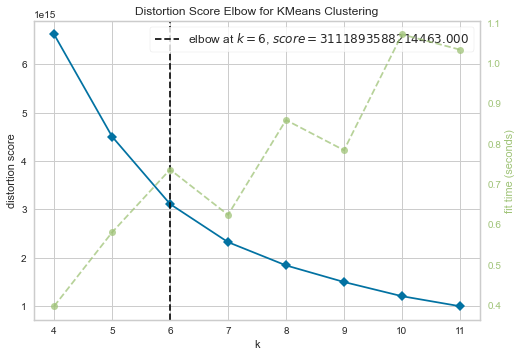

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
#Use elbow curve method to determine best number of clusters in artistsTracksbyGenre dataset
from yellowbrick.cluster import KElbowVisualizer

#Cluster based only on numeric values in dataset
X = artistsTracksbyGenres.select_dtypes(np.number)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figured

In [15]:
#Use kmeans to cluster data into distinct clusters, using 'elbow' (dashed vertical line) in above plot
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=6, n_jobs=-1))])
cluster_pipeline.fit(X)
artistsTracksbyGenres['cluster'] = cluster_pipeline.predict(X)

C:\Users\MariaZatko\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


##### Visualize the genre clusters

In [16]:
#Use TSNE method to collapse dataset into 2-dimensional space for visualization
from sklearn.manifold import TSNE 

tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=2))])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = artistsTracksbyGenres['genres']
projection['cluster'] = artistsTracksbyGenres['cluster']

#from sklearn.decomposition import PCA
#pca_pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])
#genre_embedding = pca_pipeline.fit_transform(X)
#projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
#projection['genres'] = artistsTracksCluster['genres']
#projection['cluster'] = artistsTracksCluster['cluster']

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20111 samples in 0.001s...
[t-SNE] Computed neighbors for 20111 samples in 14.149s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20111
[t-SNE] Computed conditional probabilities for sample 2000 / 20111
[t-SNE] Computed conditional probabilities for sample 3000 / 20111
[t-SNE] Computed conditional probabilities for sample 4000 / 20111
[t-SNE] Computed conditional probabilities for sample 5000 / 20111
[t-SNE] Computed conditional probabilities for sample 6000 / 20111
[t-SNE] Computed conditional probabilities for sample 7000 / 20111
[t-SNE] Computed conditional probabilities for sample 8000 / 20111
[t-SNE] Computed conditional probabilities for sample 9000 / 20111
[t-SNE] Computed conditional probabilities for sample 10000 / 20111
[t-SNE] Computed conditional probabilities for sample 11000 / 20111
[t-SNE] Computed conditional probabilities for sample 12000 / 20111
[t-SNE] Computed conditional probabilities for sa

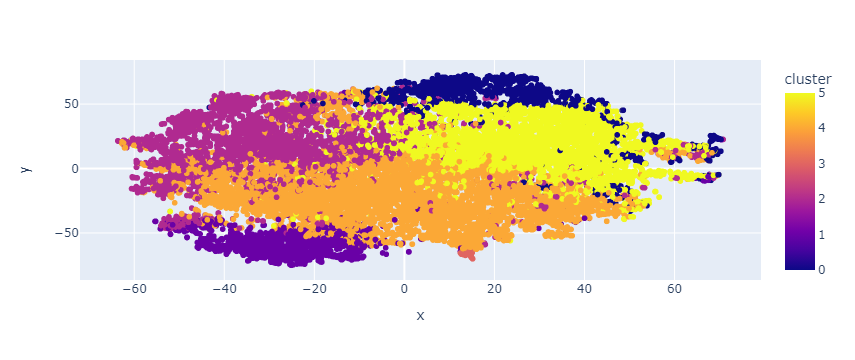

In [17]:
#Plot the reduced clusters
fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'])
fig.show()

In [18]:
#How many genres are in each cluster?
artistsTracksbyGenres.groupby('cluster')['genres'].count()

#First pass at generalizing clusters
# 0 = calming music
# 1 = rap/hip-hop
# 2 = metal/punk/rock
# 3 = dance
# 4 = pop-ish
# 5 = folky/alternative

cluster
0    1667
1    1652
2    4280
3      68
4    7418
5    5026
Name: genres, dtype: int64

In [21]:
#Merge cluster id back to artistsTracks dataset
artistsTracks = artistsTracks.merge(artistsTracksbyGenres[['genres','cluster']], on='genres')